In [161]:
import datasets
import roc_auc
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator

In [43]:
class EstimatorKNN(BaseEstimator):
    def __init__(self, n_neighbors=3, algorithm='ball_tree'):
        self.param = {}
        self.param['n_neighbors'] = n_neighbors
        self.param['algorithm'] = algorithm
        self.estimator = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm)

    def fit(self, x):
        self.estimator.fit(x)
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        distances, indices = self.estimator.kneighbors(x)
        outlier_level = distances[:,-1]
        return outlier_level

    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        #return self.estimator.get_params(deep)
        return self.param

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self
    
    def get_type(self):
        return 'kNN'

In [164]:
importlib.reload(roc_auc)

<module 'roc_auc' from 'roc_auc.ipynb'>

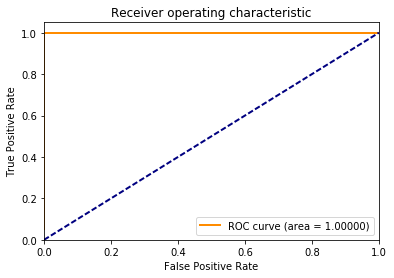

auc 1.00000


In [163]:
import importlib
#importlib.reload(roc_auc)
import roc_auc
import datasets

def eval01():
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    n_record = 10
    drop_interval = 2
    ma_window = 2
    normalize = True
    
    # get data
    dfl_b = datasets.get_data(ds, title='01_01_01', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:3]
    dfl_n = datasets.get_data(ds, title='01_01_02', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title='01_02_02', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = EstimatorKNN()
    model.fit(data_b)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
#    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=False)

    print('auc %.05f' % (auc))
    
eval01()

In [1]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
%matplotlib inline

In [10]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    for _ in range(size_of_mini_batch):
        d = random.choice(train_data)
        inputs  = np.append(inputs, d)
    inputs  = inputs.reshape(-1, length_of_sequences)
    return inputs

#''' pred area judgement from rssi
data_path                   = './input/data.csv'
num_of_sequence_length      = 10
num_of_hidden_nodes         = 20
num_of_training_epochs      = 100
size_of_mini_batch          = 10
size_of_test_batch          = 4
learning_rate               = 0.02
train_dir                   = 'train'

train_data = np.array([[-50., -50., -50., -51., -49., -47., -45., -44., -45., -49.],
                       [-53., -53., -53., -53., -51., -50., -50., -51., -52., -52.],
                       [-54., -54., -54., -53., -52., -50., -48., -48., -47., -46.],
                       [-49., -47., -46., -45., -44., -44., -42., -41., -41., -41.]])
test_data = np.array([[-63., -63., -64., -64., -63., -63., -63., -63., -63., -62.],
                      [-58., -59., -59., -59., -61., -61., -59., -56., -55., -54.],
                      [-65., -62., -62., -62., -61., -61., -60., -59., -60., -60.],
                      [-61., -61., -62., -62., -62., -61., -60., -61., -60., -60.]])
print(train_data)
print(test_data)
train_data *= -0.01
test_data *= -0.01

[[-50. -50. -50. -51. -49. -47. -45. -44. -45. -49.]
 [-53. -53. -53. -53. -51. -50. -50. -51. -52. -52.]
 [-54. -54. -54. -53. -52. -50. -48. -48. -47. -46.]
 [-49. -47. -46. -45. -44. -44. -42. -41. -41. -41.]]
[[-63. -63. -64. -64. -63. -63. -63. -63. -63. -62.]
 [-58. -59. -59. -59. -61. -61. -59. -56. -55. -54.]
 [-65. -62. -62. -62. -61. -61. -60. -59. -60. -60.]
 [-61. -61. -62. -62. -62. -61. -60. -61. -60. -60.]]


In [16]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

with tf.name_scope("inference") as scope:
    weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
    bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
    bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")
    hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
    output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

with tf.name_scope("loss") as scope:
    square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
    loss_op      = square_error

with tf.name_scope("training") as scope:
    training_op = optimizer.minimize(loss_op)

init = tf.initialize_all_variables()

sess = tf.Session()
saver = tf.train.Saver()
sess.run(init)
accuracy_results = []

for epoch in range(num_of_training_epochs):
    data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)

    train_dict = {
        input_ph:      data,
        supervisor_ph: data,
        batch_size_ph: size_of_mini_batch,
    }
    sess.run(training_op, feed_dict=train_dict)

    if (epoch + 1) % 10 == 0:
        train_loss = sess.run(loss_op, feed_dict=train_dict)

        # eval accuracy
        data = make_mini_batch(train_data, size_of_mini_batch, num_of_sequence_length)
        pred_dict = {
            input_ph:      data,
            supervisor_ph: data,
            batch_size_ph: size_of_test_batch,
        }
        accuracy_results.append([epoch, train_loss])
        preddata = sess.run(output_op, feed_dict=pred_dict)
        print("train#%d, train loss: %e" % (epoch + 1, train_loss))

for epoch in range(len(train_data)):
    data = train_data[epoch].reshape(-1, num_of_sequence_length)

    train_dict = {
        input_ph:      data,
        supervisor_ph: data,
        batch_size_ph: 1,
    }

    train_loss = sess.run(loss_op, feed_dict=train_dict)
    print('test w/ train #.%d %f' % (epoch, train_loss))

for epoch in range(len(test_data)):
    data = test_data[epoch].reshape(-1, num_of_sequence_length)

    train_dict = {
        input_ph:      data,
        supervisor_ph: data,
        batch_size_ph: 1,
    }

    train_loss = sess.run(loss_op, feed_dict=train_dict)
    print('test w/ test  #.%d %f' % (epoch, train_loss))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
train#10, train loss: 2.262008e-03
train#20, train loss: 1.666886e-03
train#30, train loss: 1.772143e-03
train#40, train loss: 9.793820e-04
train#50, train loss: 8.783604e-04
train#60, train loss: 1.294891e-03
train#70, train loss: 6.424444e-04
train#80, train loss: 1.095755e-03
train#90, train loss: 8.701695e-04
train#100, train loss: 8.573295e-04
test w/ train #.0 0.000344
test w/ train #.1 0.001342
test w/ train #.2 0.000786
test w/ train #.3 0.001805
test w/ test  #.0 0.020351
test w/ test  #.1 0.009322
test w/ test  #.2 0.015336
test w/ test  #.3 0.015023


,epoch,train_loss
0,1,0.016091
1,3,0.005841
2,5,0.011674
3,7,0.011374
4,9,0.006647


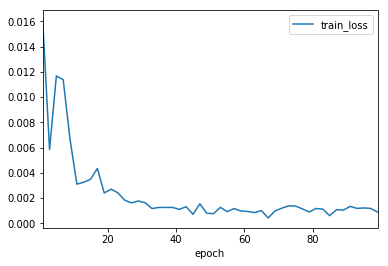

In [7]:
## result graph　
import matplotlib
import matplotlib.pyplot as plt

df = pd.DataFrame({
        'epoch': [x[0] for x in accuracy_results],
        'train_loss': [x[1] for x in accuracy_results]
    })
#        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='train_loss')
df.head()